**Import Required Libraries** - 
This cell imports essential Python libraries including TensorFlow, Transformers, Pandas, NumPy, and plotting tools like Matplotlib and Seaborn


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import itertools
from itertools import product
import shap
import re
import string
import scikeras
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('float32')  # Using this instead of float16 which is safe for CPU
from transformers import TFDistilBertModel
from transformers import DistilBertTokenizerFast
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, LeakyReLU, Attention, Lambda, Embedding, LSTM, Bidirectional, BatchNormalization, SpatialDropout1D, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

import nltk
from nltk import pos_tag
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag.perceptron import PerceptronTagger
from scikeras.wrappers import KerasClassifier
print(KerasClassifier.__module__)
from wordcloud import WordCloud
from textblob import TextBlob

D:\anaconda3\envs\tf_gpu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



scikeras.wrappers


**Print Library Versions** - Displays the installed versions of `scikeras` and `scikit-learn` to confirm compatibility.

In [4]:
print("Scikeras:", scikeras.__version__)
print("Scikit-learn:", sklearn.__version__)

Scikeras: 0.13.0
Scikit-learn: 1.6.1


**Suppress Warnings and Logs** - Reduces clutter by suppressing TensorFlow and Python warnings and logs.

In [6]:
# Suppressing Python warnings
import warnings
warnings.filterwarnings('ignore')

# Suppressing TensorFlow warnings and logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR

import logging
tf.get_logger().setLevel(logging.ERROR)  # suppress TF warnings inside notebooks

### Extract, Load and Transform (ETL)
**Load Glassdoor Dataset** - Loads the dataset from a specified file path using Pandas.

In [8]:
# Loading the Glassdoor dataset
df = pd.read_csv("C://Users//Devanshu Singh//Desktop//All Folders//projects//Deep Learning//filtered_firms_50-60k.csv")
df.head()

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons
0,AFH-Wealth-Management,42099,,Current Employee,NaN,2,4.0,3.0,NaN,2.0,3.0,3.0,x,o,r,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication."
1,AFH-Wealth-Management,42349,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",2,3.0,1.0,NaN,2.0,1.0,4.0,x,o,r,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...
2,AFH-Wealth-Management,42397,Office Administrator,"Current Employee, less than 1 year","Bromsgrove, England, England",1,1.0,1.0,NaN,1.0,1.0,1.0,x,o,x,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very..."
3,AFH-Wealth-Management,42476,,Current Employee,NaN,5,2.0,3.0,NaN,2.0,2.0,3.0,x,o,r,Over promised under delivered,Nice staff to work with,No career progression and salary is poor
4,AFH-Wealth-Management,42483,Office Administrator,"Current Employee, more than 1 year","Bromsgrove, England, England",1,2.0,1.0,NaN,2.0,1.0,1.0,x,o,x,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr..."


### Exploratory Data Analysis of the Glassdoor Reviews dataset and preprocessing

**Record Counts of the Firms** - Record Counts of the Top 10 firms with highest records.

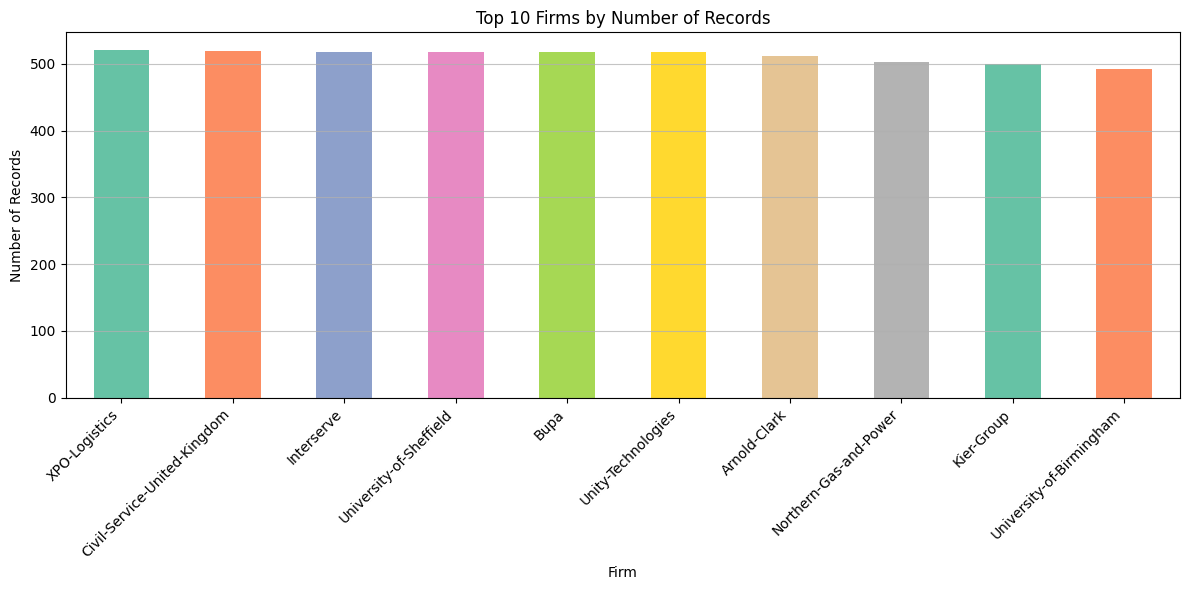

In [11]:
# Get top 10 firms by record count
top_10_firms = df['firm'].value_counts().head(10)

# Plotting as a vertical bar chart
plt.figure(figsize=(12, 6))
top_10_firms.plot(kind='bar', color=plt.cm.Set2.colors)
plt.title('Top 10 Firms by Number of Records')
plt.xlabel('Firm')
plt.ylabel('Number of Records')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

**Descriptive Analysis** - Describing the dataset.

In [13]:
# Display basic statistics
print("\nDescriptive statistics:")
df.describe()


Descriptive statistics:


,date_review,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt
count,50301.000000,50301.000000,42489.000000,41854.000000,9652.000000,42592.000000,42287.000000,42120.000000
mean,43444.816862,3.580207,3.458683,3.495365,3.818069,3.285570,3.305933,3.161681
std,784.980365,1.382550,1.399069,1.478076,1.328553,1.434748,1.368951,1.502129
min,39610.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,42958.000000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000
50%,43628.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000
75%,44120.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000
max,44354.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


**Missing Values Visualization** - Identifies and plots columns that have missing values.

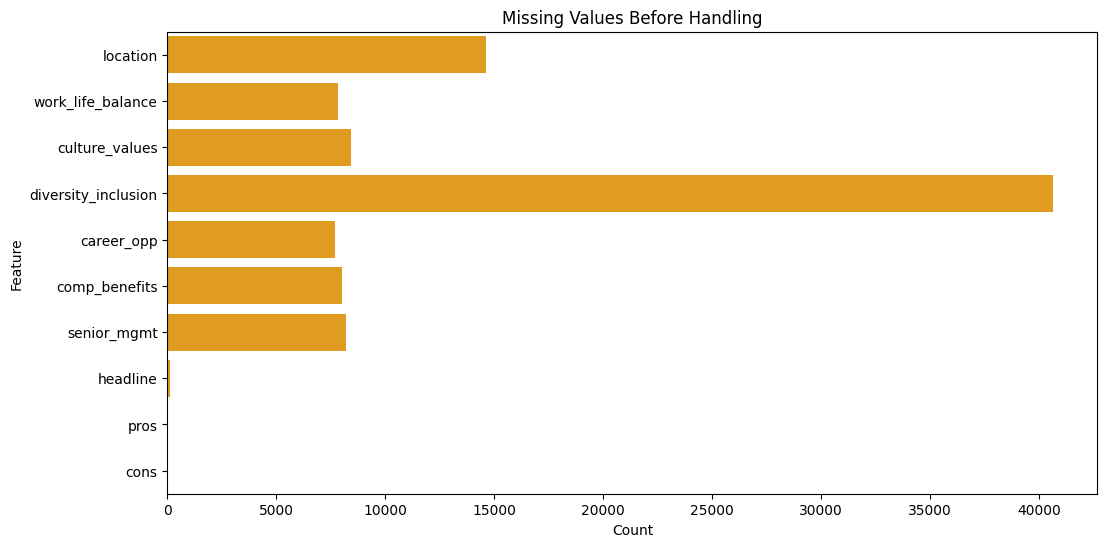

In [15]:
# Identifying missing values
missing_before = df.isnull().sum()
missing_before = missing_before[missing_before > 0]

# Plotting missing values in a bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_before.values, y=missing_before.index, color='orange')
plt.title("Missing Values Before Handling")
plt.xlabel("Count")
plt.ylabel("Feature")
plt.show()

**Clean Dataset Columns** - Filters necessary features and drops rows with missing key text columns like `headline`, `pros`, and `cons`.

In [17]:
# Defining the Dataframe
df = df[['headline', 'pros', 'cons', 'overall_rating', 'job_title', 'location', 'current',
         'recommend', 'ceo_approv', 'outlook', 'work_life_balance', 'culture_values', 'date_review',
         'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt']].dropna(subset=['headline', 'pros', 'cons'])

# Tokenizer, stopwords, lemmatizer setup
tokenizer = TreebankWordTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Creating helper functions
def correct_contractions(text):
    contractions = {
        "don't": "do not", "can't": "cannot", "won't": "will not",
        "i'm": "i am", "it's": "it is", "you're": "you are", "they're": "they are",
    }
    for word, replacement in contractions.items():
        text = text.replace(word, replacement)
    return text

def clean_text(text):
    text = re.sub(r'[\U0001F600-\U0001F64F]', '', text)  # Remove emojis
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\b\w{20,}\b', '', text)  # Remove long words
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub("[" + re.escape(string.punctuation) + "]", "", text)  # Remove punctuation
    return text

# Manually loading the default tagger
_perceptron_tagger = PerceptronTagger()

# Taggin Filtering (only keep content words)
def keep_content_words(text):
    tokens = tokenizer.tokenize(text)
    tagged = _perceptron_tagger.tag(tokens)
    keep_tags = ['NN', 'NNS', 'NNP', 'VB', 'VBD', 'JJ', 'RB']  # Nouns, Verbs, Adjectives, Adverbs
    return ' '.join([word for word, tag in tagged if tag in keep_tags])

# Cleaning and lemmatizing helper function
def clean_and_lemmatize(text):
    text = correct_contractions(text.lower())  # Applying contraction correction
    text = clean_text(text)  # Applying text cleaning
    text = keep_content_words(text)  # Applying POS filtering
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Applying preprocessing steps
df['combined_text'] = ("Pros: " + df['pros'] + ". Cons: " + df['cons'] + ". Headline: " + df['headline']).str.lower()
df['clean_text'] = df['combined_text'].apply(clean_and_lemmatize)

# Generating Bigrams
def generate_bigrams(text):
    tokens = tokenizer.tokenize(text)
    return ['_'.join(pair) for pair in zip(tokens, tokens[1:])]
df['bigrams'] = df['clean_text'].apply(generate_bigrams)

# Sentiment analysis
def get_sentiment(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return 0.0
df['pros_sentiment'] = df['pros'].apply(get_sentiment)
df['cons_sentiment'] = df['cons'].apply(get_sentiment)
df['headline_sentiment'] = df['headline'].apply(get_sentiment)

# Applying cleaned text as the review text
df['review_text'] = df['clean_text']

# TF-IDF Meta Features
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['clean_text'])

# Adding TF-IDF features as meta features
df['tfidf_sum'] = tfidf_matrix.sum(axis=1).A1
df['tfidf_max'] = tfidf_matrix.max(axis=1).toarray().ravel()
df['tfidf_nonzero'] = (tfidf_matrix != 0).sum(axis=1).A1

# Dropping rows with missing review_text or overall_rating
df.dropna(subset=["review_text", "overall_rating"], inplace=True)

# Imputing structured feature missing values
df["location"].fillna("Unknown", inplace=True)
for col in ["work_life_balance", "culture_values", "diversity_inclusion",
            "career_opp", "comp_benefits", "senior_mgmt"]:
    df[col].fillna(df[col].median(), inplace=True)

# Feature Interactions
df['work_culture_interaction'] = df['work_life_balance'] * df['culture_values']
df['career_comp_interaction'] = df['career_opp'] * df['comp_benefits']

print('Missing Values handled Successfully!')
df.head()

Missing Values handled Successfully!


,headline,pros,cons,overall_rating,job_title,location,current,recommend,ceo_approv,outlook,...,bigrams,pros_sentiment,cons_sentiment,headline_sentiment,review_text,tfidf_sum,tfidf_max,tfidf_nonzero,work_culture_interaction,career_comp_interaction
0,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",2,,Unknown,Current Employee,x,o,r,...,"[pro_friendly, friendly_new, new_staff, staff_...",0.352399,-0.400000,-0.15,pro friendly new staff easy ethic con poor sal...,3.300678,0.617887,15,12.0,6.0
1,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,2,Office Administrator,"Bromsgrove, England, England","Current Employee, more than 1 year",x,o,r,...,"[pro_friendly, friendly_helpful, helpful_colle...",0.375000,-0.108000,0.30,pro friendly helpful colleague con poor salary...,3.839196,0.500387,19,3.0,2.0
2,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",1,Office Administrator,"Bromsgrove, England, England","Current Employee, less than 1 year",x,o,x,...,"[pro_get, get_job, job_even, even_experience, ...",0.433333,-0.104821,-0.35,pro get job even experience finance con low sa...,4.794502,0.335292,27,1.0,1.0
3,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,5,,Unknown,Current Employee,x,o,r,...,"[pro_nice, nice_staff, staff_work, work_con, c...",0.600000,-0.400000,0.00,pro nice staff work con career progression sal...,2.912689,0.415013,10,6.0,4.0
4,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",1,Office Administrator,"Bromsgrove, England, England","Current Employee, more than 1 year",x,o,x,...,"[pro_get, get_job, job_nice, nice_colleague, c...",0.516667,-0.233333,0.00,pro get job nice colleague con abysmal pay min...,4.703119,0.305752,26,2.0,2.0


**Token Length Analysis** - Loads the DistilBERT tokenizer and computes token lengths for each review for determining the max_length.

Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors


count    50192.000000
mean        28.954395
std         29.203382
min          3.000000
25%         14.000000
50%         20.000000
75%         33.000000
max        892.000000
Name: review_text, dtype: float64


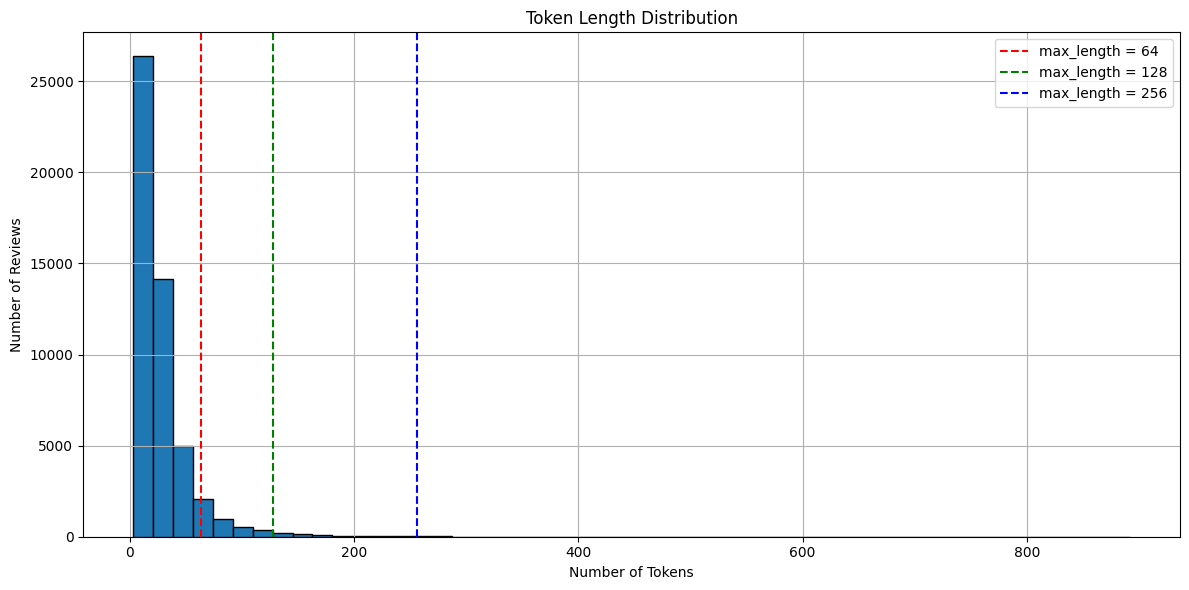

In [19]:
# Loading the DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Computing token lengths
token_lengths = df["review_text"].apply(lambda x: len(tokenizer.tokenize(x)))

# Printing descriptive stats
print(token_lengths.describe())

# Plotting token length distribution
plt.figure(figsize=(12, 6))
plt.hist(token_lengths, bins=50, edgecolor='black')
plt.axvline(64, color='red', linestyle='--', label='max_length = 64')
plt.axvline(128, color='green', linestyle='--', label='max_length = 128')
plt.axvline(256, color='blue', linestyle='--', label='max_length = 256')
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Reviews")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Encode Categorical Features** - Encodes text-based categorical fields (e.g., job title, location) as numerical codes for modeling.

In [21]:
# Encoding categorical structured features
for col in ["job_title", "location", "current", "recommend", "ceo_approv", "outlook"]:
    df[col] = df[col].astype("category").cat.codes

# Finalizing structured features for model input
structured_features = df[[
    "job_title", "location", "current", "recommend", "ceo_approv", "outlook",
    "work_life_balance", "culture_values", "diversity_inclusion",
    "career_opp", "comp_benefits", "senior_mgmt"
]].astype("float32").values

print(structured_features.shape)

# Resetting index
df.reset_index(drop=True, inplace=True)
df.head()

(50192, 12)


,headline,pros,cons,overall_rating,job_title,location,current,recommend,ceo_approv,outlook,...,bigrams,pros_sentiment,cons_sentiment,headline_sentiment,review_text,tfidf_sum,tfidf_max,tfidf_nonzero,work_culture_interaction,career_comp_interaction
0,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",2,0,1995,3,2,0,1,...,"[pro_friendly, friendly_new, new_staff, staff_...",0.352399,-0.400000,-0.15,pro friendly new staff easy ethic con poor sal...,3.300678,0.617887,15,12.0,6.0
1,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,2,5644,304,5,2,0,1,...,"[pro_friendly, friendly_helpful, helpful_colle...",0.375000,-0.108000,0.30,pro friendly helpful colleague con poor salary...,3.839196,0.500387,19,3.0,2.0
2,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",1,5644,304,4,2,0,3,...,"[pro_get, get_job, job_even, even_experience, ...",0.433333,-0.104821,-0.35,pro get job even experience finance con low sa...,4.794502,0.335292,27,1.0,1.0
3,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,5,0,1995,3,2,0,1,...,"[pro_nice, nice_staff, staff_work, work_con, c...",0.600000,-0.400000,0.00,pro nice staff work con career progression sal...,2.912689,0.415013,10,6.0,4.0
4,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",1,5644,304,5,2,0,3,...,"[pro_get, get_job, job_nice, nice_colleague, c...",0.516667,-0.233333,0.00,pro get job nice colleague con abysmal pay min...,4.703119,0.305752,26,2.0,2.0


**Rating Distribution Plot** - Visualizes distributions of various rating categories (overall, work-life balance, etc.).

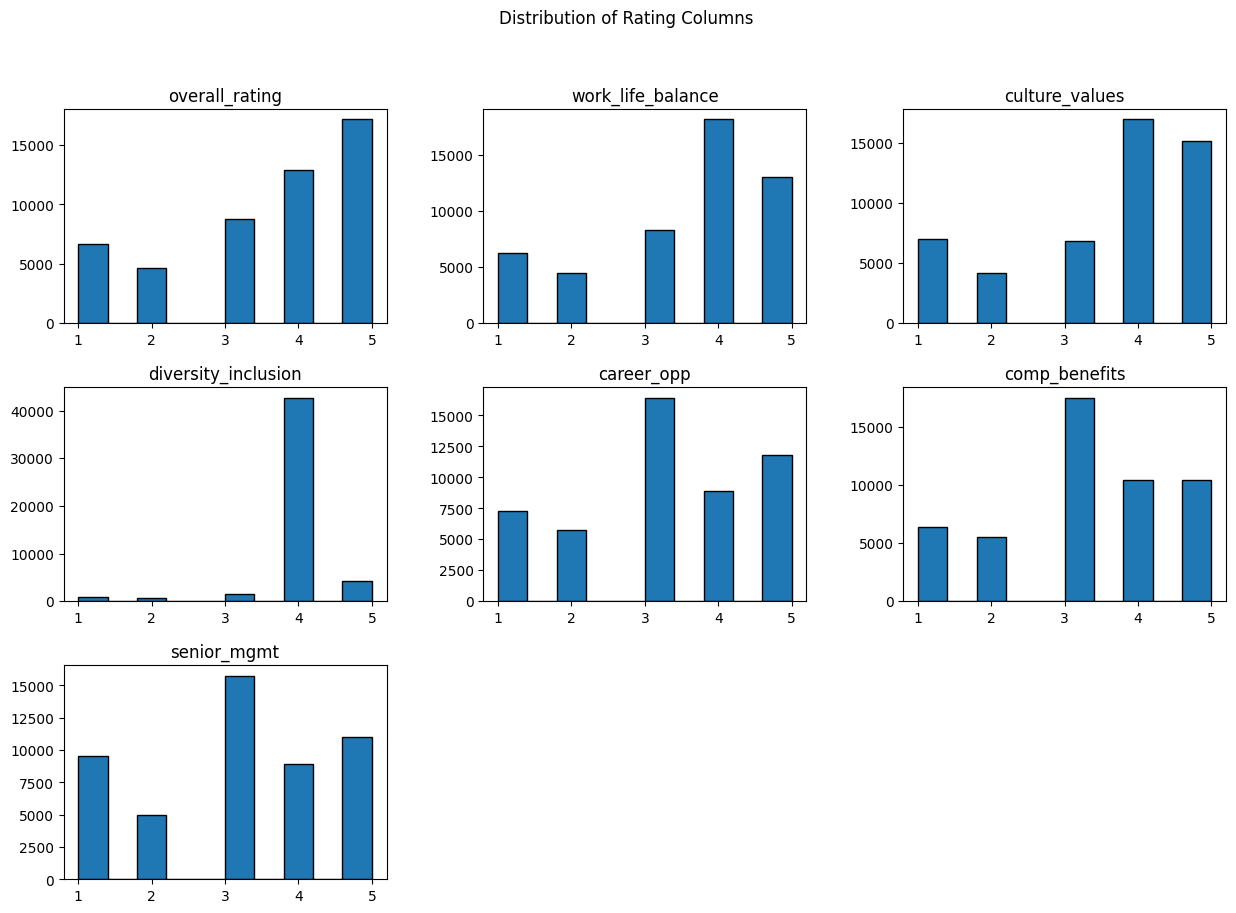

In [23]:
# Plotting Rating Distributions
numeric_cols = ['overall_rating', 'work_life_balance', 'culture_values',
                'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt']
df[numeric_cols].hist(bins=10, figsize=(15, 10), edgecolor='black', grid=False)
plt.suptitle("Distribution of Rating Columns")
plt.show()

**Top Reviewed Job Titles** - Bar plot showing the most frequently reviewed job roles in the dataset.

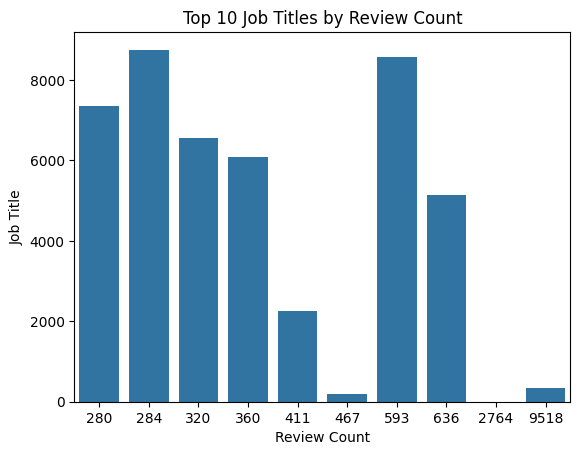

In [25]:
# Plotting Top Reviewed Job Titles
top_jobs = df['job_title'].value_counts().head(10)
sns.barplot(x=top_jobs.values, y=top_jobs.index)
plt.title("Top 10 Job Titles by Review Count")
plt.xlabel("Review Count")
plt.ylabel("Job Title")
plt.show()

**Rating Trends Over Time** - Creates a line chart of the average overall rating by month.

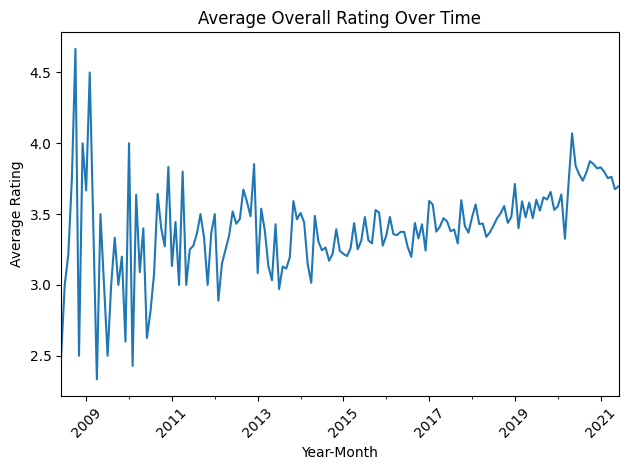

In [27]:
# Plotting Rating Over Time
df['date_review'] = pd.to_datetime(df['date_review'], origin='1899-12-30', unit='D')
df['year_month'] = df['date_review'].dt.to_period('M')
rating_trend = df.groupby('year_month')['overall_rating'].mean()
rating_trend.plot()
plt.title("Average Overall Rating Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Employee Sentiment Counts** - Visualizes counts of employee recommendations, CEO approval, and company outlook.

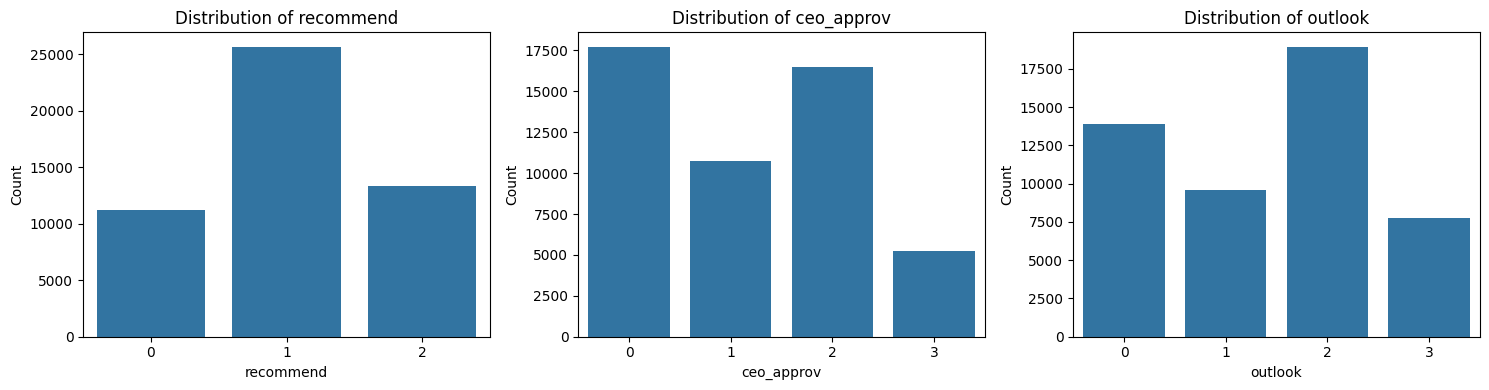

In [29]:
# Plotting Recommend / CEO Approval / Outlook Counts
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(['recommend', 'ceo_approv', 'outlook']):
    sns.countplot(x=df[col], ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Count")

plt.tight_layout()
plt.show()

**Word Clouds for Pros & Cons** - Generates word clouds from the 'pros' and 'cons' text fields for visual sentiment insight.

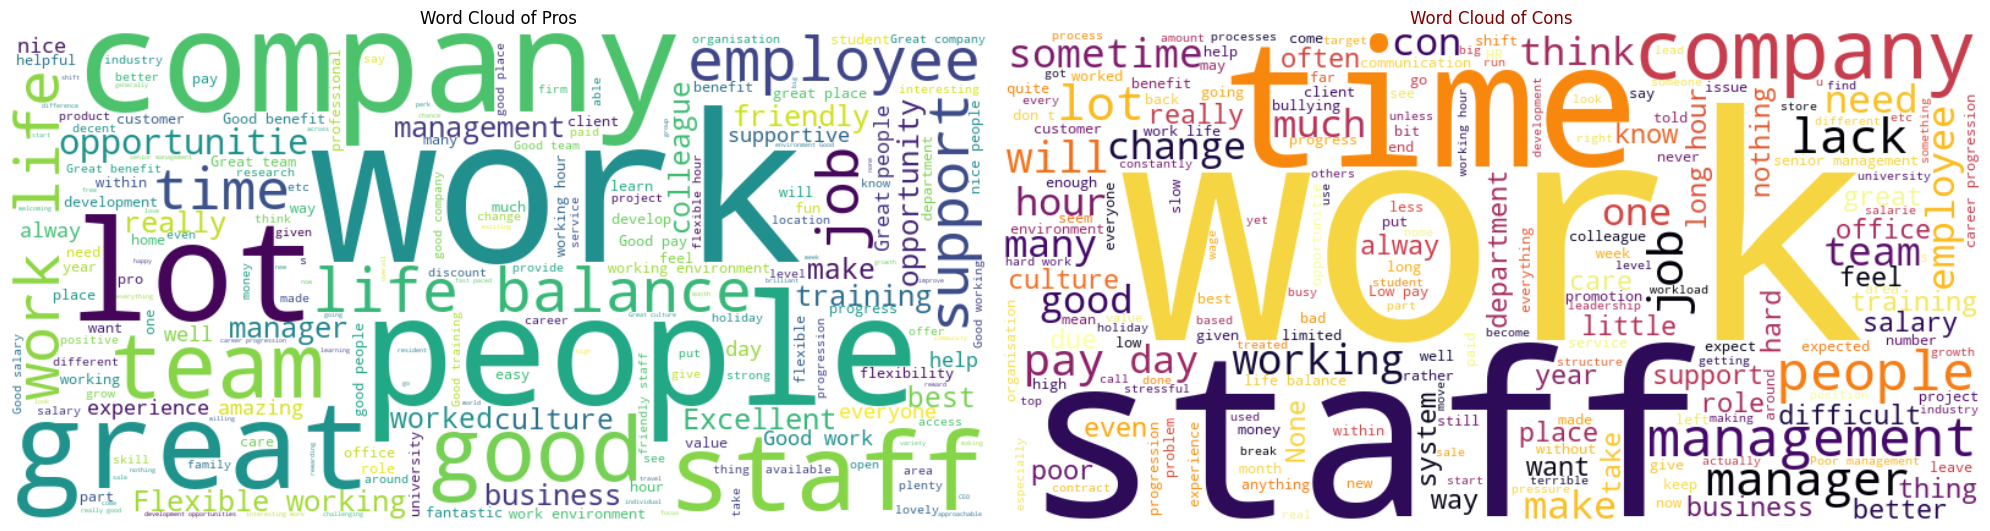

In [31]:
# Plotting Word Clouds for Pros and Cons
pros_text = ' '.join(df['pros'].dropna())
cons_text = ' '.join(df['cons'].dropna())

# Light and vibrant for pros, dark for cons
pros_wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(pros_text)
cons_wc = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(cons_text)

# Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(pros_wc, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Word Cloud of Pros")

axes[1].imshow(cons_wc, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Word Cloud of Cons", color='maroon')

plt.tight_layout()
plt.show()

**Current vs Former Employee Ratings** - Compares satisfaction ratings between current and former employees using a boxplot.

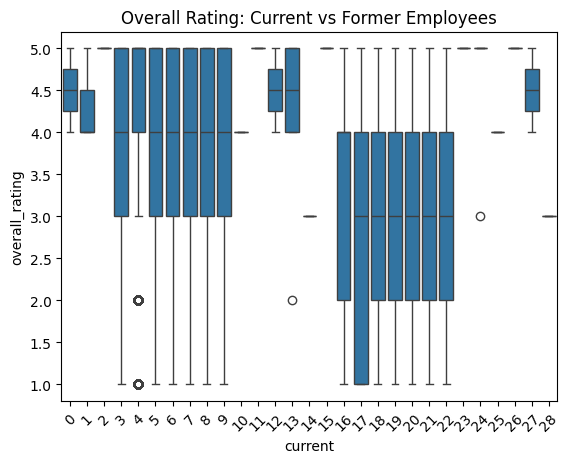

In [33]:
# Plotting Current vs Former Employee Rating Comparison
sns.boxplot(x='current', y='overall_rating', data=df)
plt.title("Overall Rating: Current vs Former Employees")
plt.xticks(rotation=45)
plt.show()

**Rating by Recommendation** - Point plot comparing overall ratings for employees who would or wouldn’t recommend the company.

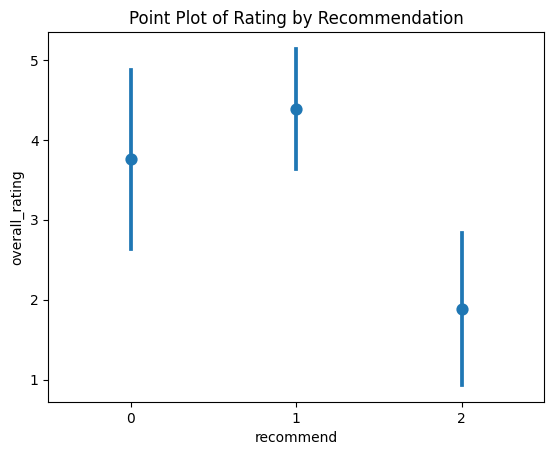

In [35]:
# Plotting Rating vs Recommend Comparison
sns.pointplot(x='recommend', y='overall_rating', data=df, ci='sd', join=False)
plt.title("Point Plot of Rating by Recommendation")
plt.show()

**Correlation Heatmap** - Visualizes the correlation between different sub-rating metrics such as work-life balance, diversity, compensation, etc.

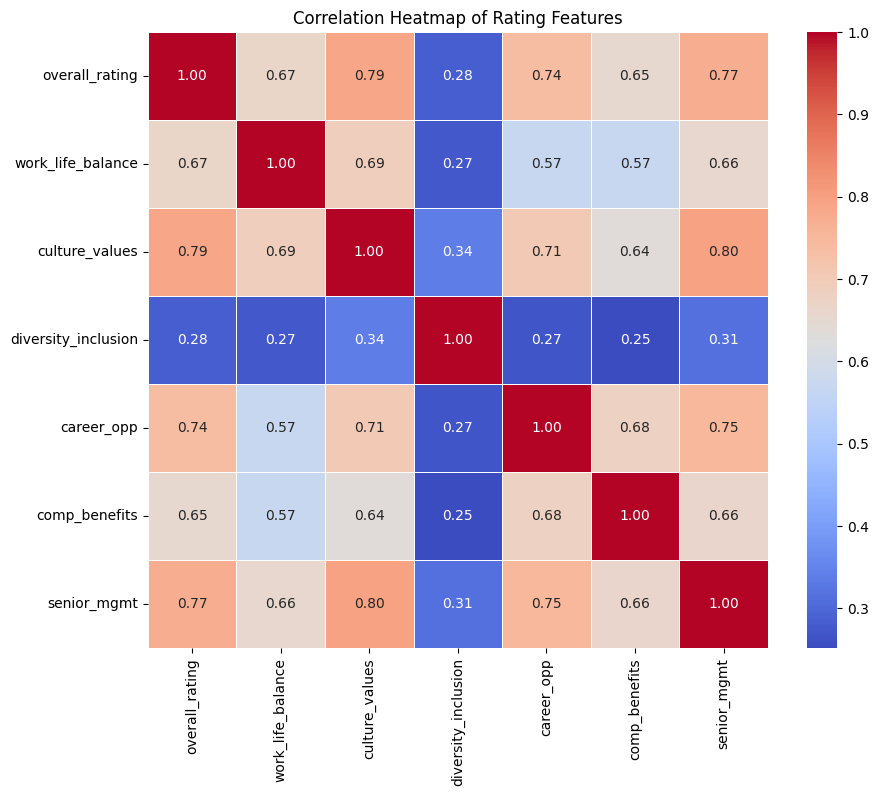

In [37]:
# Plotting Correlation Heatmap between all numerical features.
plt.figure(figsize=(10, 8))
corr = df[['overall_rating', 'work_life_balance', 'culture_values', 'diversity_inclusion',
           'career_opp', 'comp_benefits', 'senior_mgmt']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap of Rating Features")
plt.show()

**Boxplot of Ratings by Outlook** - Shows how employee outlook affects ratings on various sub-categories like career opportunities or senior management.

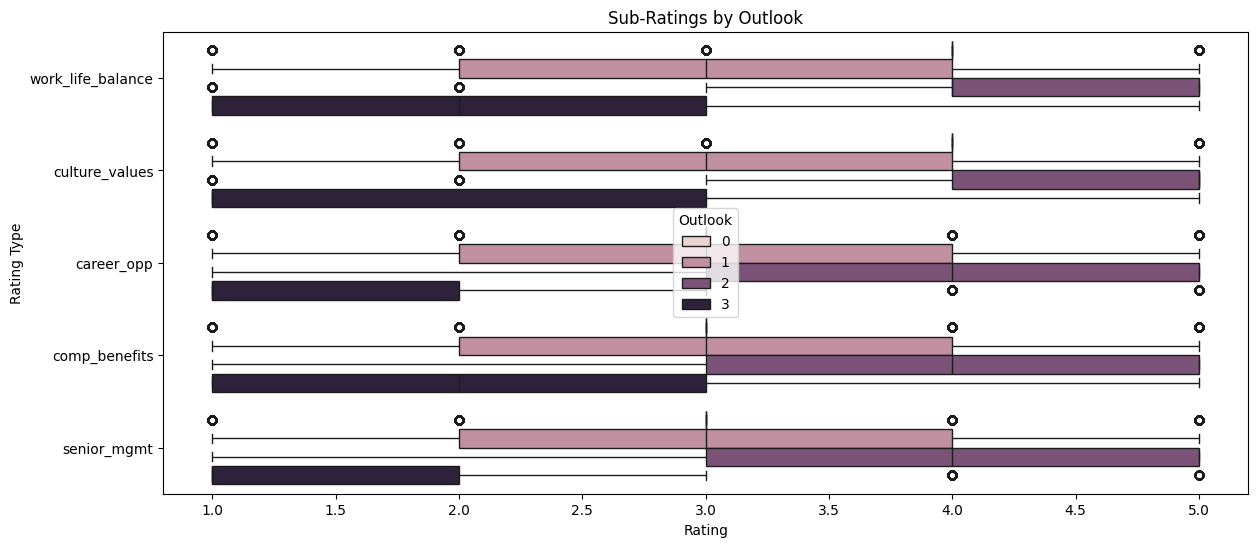

In [39]:
# Plotting Boxplot of Ratings by Outlook
melted = df.melt(id_vars='outlook', value_vars=['work_life_balance', 'culture_values',
                                                'career_opp', 'comp_benefits', 'senior_mgmt'])
plt.figure(figsize=(14, 6))
sns.boxplot(x='value', y='variable', hue='outlook', data=melted, orient='h')
plt.title("Sub-Ratings by Outlook")
plt.xlabel("Rating")
plt.ylabel("Rating Type")
plt.legend(title="Outlook")
plt.show()

**CEO Approval vs Recommendation** - Count plot comparing how CEO approval aligns with employee recommendation rates.

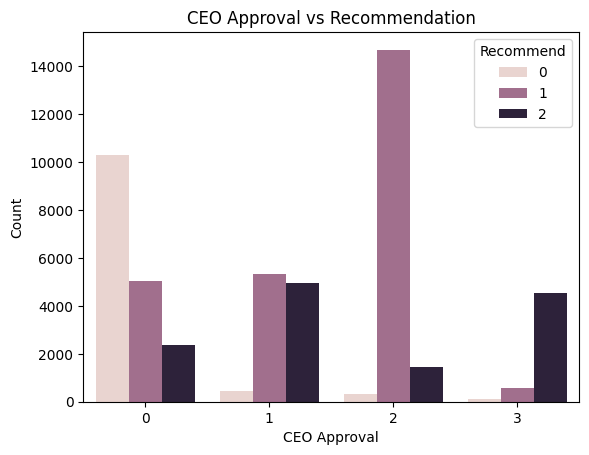

In [41]:
# Plotting Countplot: CEO Approval vs Recommend
sns.countplot(x='ceo_approv', hue='recommend', data=df)
plt.title("CEO Approval vs Recommendation")
plt.xlabel("CEO Approval")
plt.ylabel("Count")
plt.legend(title='Recommend')
plt.show()

**Average Ratings by Job Title** - Displays average sub-ratings (e.g., work-life balance) grouped by top job titles.

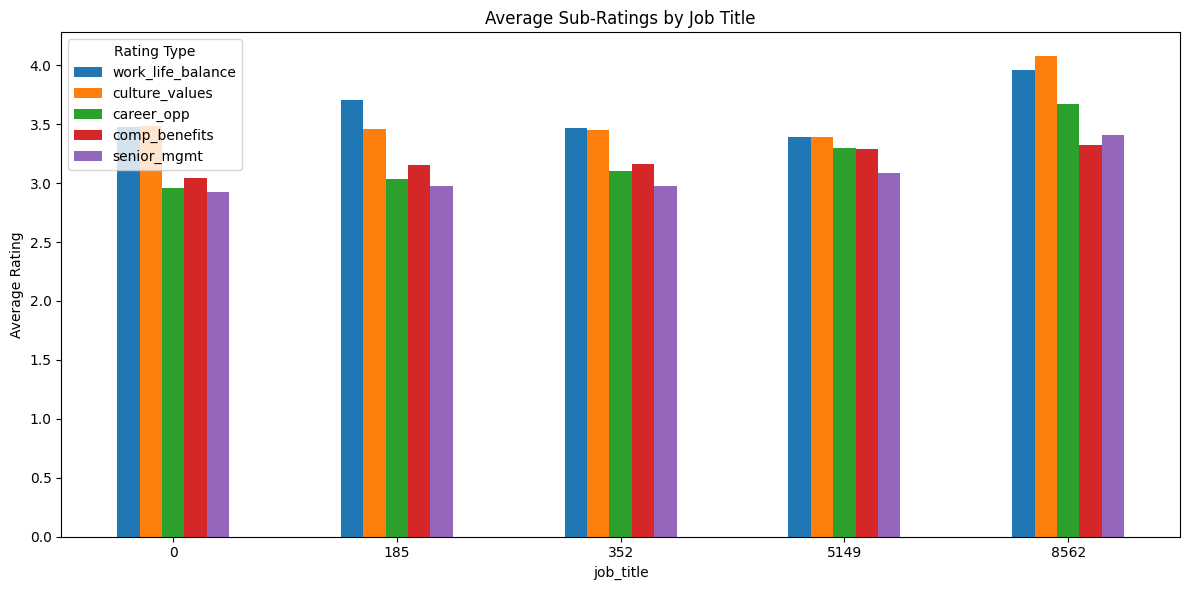

In [43]:
# Plotting Bar Plot of Average Sub-Ratings by Job Title
top_jobs = df['job_title'].value_counts().head(5).index.tolist()
subset = df[df['job_title'].isin(top_jobs)]

avg_subratings = subset.groupby('job_title')[['work_life_balance', 'culture_values',
                                              'career_opp', 'comp_benefits', 'senior_mgmt']].mean()

avg_subratings.plot(kind='bar', figsize=(12, 6))
plt.title("Average Sub-Ratings by Job Title")
plt.ylabel("Average Rating")
plt.xticks(rotation=360)
plt.legend(title="Rating Type")
plt.tight_layout()
plt.show()

### 1. Prediction
**Normalize Numerical Features** - Applies standard scaling to numerical rating features before modeling.

In [45]:
# Scaling numeric columns
num_cols = ['work_life_balance', 'culture_values', 'diversity_inclusion',
            'career_opp', 'comp_benefits', 'senior_mgmt']

df[num_cols] = StandardScaler().fit_transform(df[num_cols])

**Label Encode Categorical Features** - Encodes string labels into numeric form for structured categorical features.

In [47]:
# Encoding categorical columns
for col in ['recommend', 'ceo_approv', 'outlook', 'current']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

**Preview Final DataFrame** - Displays the first few rows of the preprocessed dataset.

In [49]:
# Displaying after preprocessing
df.head()

,headline,pros,cons,overall_rating,job_title,location,current,recommend,ceo_approv,outlook,...,pros_sentiment,cons_sentiment,headline_sentiment,review_text,tfidf_sum,tfidf_max,tfidf_nonzero,work_culture_interaction,career_comp_interaction,year_month
0,"Young colleagues, poor micro management",Very friendly and welcoming to new staff. Easy...,"Poor salaries, poor training and communication.",2,0,1995,22,2,0,1,...,0.352399,-0.400000,-0.15,pro friendly new staff easy ethic con poor sal...,3.300678,0.617887,15,12.0,6.0,2015-04
1,"Excellent staff, poor salary","Friendly, helpful and hard-working colleagues",Poor salary which doesn't improve much with pr...,2,5644,304,24,2,0,1,...,0.375000,-0.108000,0.30,pro friendly helpful colleague con poor salary...,3.839196,0.500387,19,3.0,2.0,2015-12
2,"Low salary, bad micromanagement",Easy to get the job even without experience in...,"Very low salary, poor working conditions, very...",1,5644,304,23,2,0,3,...,0.433333,-0.104821,-0.35,pro get job even experience finance con low sa...,4.794502,0.335292,27,1.0,1.0,2016-01
3,Over promised under delivered,Nice staff to work with,No career progression and salary is poor,5,0,1995,22,2,0,1,...,0.600000,-0.400000,0.00,pro nice staff work con career progression sal...,2.912689,0.415013,10,6.0,4.0,2016-04
4,client reporting admin,"Easy to get the job, Nice colleagues.","Abysmal pay, around minimum wage. No actual tr...",1,5644,304,24,2,0,3,...,0.516667,-0.233333,0.00,pro get job nice colleague con abysmal pay min...,4.703119,0.305752,26,2.0,2.0,2016-04


### 1. Prediction using LSTM

**Preparing dataframe** - Preparing the dataframe making it suitable for working with LSTM model.

In [52]:
# Preparing Dataframe df
df = df.dropna(subset=['headline', 'pros', 'cons', 'job_title', 'location', 'overall_rating'])

# Combining text columns
text_data = df['headline'].astype(str) + " " + df['pros'].astype(str) + " " + df['cons'].astype(str)

# Labelling (shift to 0-based for sparse_categorical_crossentropy)
y = df['overall_rating'].astype(int).values - 1

# Encoding job titles and locations
job_le = LabelEncoder()
loc_le = LabelEncoder()
job_input_seq = job_le.fit_transform(df['job_title'].astype(str))
loc_input_seq = loc_le.fit_transform(df['location'].astype(str))
job_vocab = len(job_le.classes_) + 1
loc_vocab = len(loc_le.classes_) + 1

# Structuring inputs
X_struct = df[['work_life_balance', 'culture_values', 'career_opp', 'comp_benefits', 'senior_mgmt']].fillna(0).values

**Tokenize Text Data and divide into Train-Test** - Tokenizes the input text using tokenizer for model input and dividing into train-test split.

In [54]:
# Tokenizing & Padding
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(text_data)
X_text_seq = text_tokenizer.texts_to_sequences(text_data)

# Setting max_len from 95th percentile
max_len = int(np.percentile([len(seq) for seq in X_text_seq], 95))
X_text_pad = pad_sequences(X_text_seq, maxlen=max_len, padding='post', truncating='post')

# Splitting the dataset into Train-Test
X_train_text, X_test_text, \
X_train_job, X_test_job, \
X_train_loc, X_test_loc, \
X_train_struct, X_test_struct, \
y_train, y_test = train_test_split(
    X_text_pad, job_input_seq, loc_input_seq, X_struct, y, test_size=0.2, random_state=42)

X_train_dict = {
    "text_input": X_train_text,
    "job_input": X_train_job,
    "loc_input": X_train_loc,
    "struct_input": X_train_struct
}
X_test_dict = {
    "text_input": X_test_text,
    "job_input": X_test_job,
    "loc_input": X_test_loc,
    "struct_input": X_test_struct
}

**Defining LSTM Model** - Computing the class weights and defining Attention Layer for building the LSTM model.

In [56]:
# Computing Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Defining Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(1,), initializer='zeros', trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)
        alpha = K.softmax(e, axis=1)
        return K.sum(inputs * alpha, axis=1)

# Building LSTM Model
def create_model(lstm_units=64, dense_units=128, dropout_rate=0.3, learning_rate=5e-4):
    text_input = Input(shape=(max_len,), name="text_input")
    job_input = Input(shape=(1,), name="job_input")
    loc_input = Input(shape=(1,), name="loc_input")
    struct_input = Input(shape=(X_struct.shape[1],), name="struct_input")

    text_emb = Embedding(input_dim=len(text_tokenizer.word_index)+1, output_dim=128)(text_input)
    text_emb = SpatialDropout1D(0.2)(text_emb)
    text_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(text_emb)
    text_vec = AttentionLayer()(text_lstm)

    job_emb = Embedding(input_dim=job_vocab, output_dim=8)(job_input)
    loc_emb = Embedding(input_dim=loc_vocab, output_dim=8)(loc_input)
    job_vec = LSTM(4)(job_emb)
    loc_vec = LSTM(4)(loc_emb)

    x = Concatenate()([text_vec, job_vec, loc_vec, struct_input])
    x = BatchNormalization()(x)
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(5, activation='softmax')(x)

    model = Model(inputs=[text_input, job_input, loc_input, struct_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

**Training and Evaluation** - Using Manual Grid Search to figure out the best parameters for the LSTM model and fitting it.

In [58]:
# Hypter-Parameter Tuning using Manual Grid Search
param_grid = {
    'lstm_units': [32, 64],
    'dense_units': [64, 128],
    'dropout_rate': [0.3, 0.4],
    'learning_rate': [1e-3, 5e-4]
}

best_score = 0
best_config = None

for lstm_units, dense_units, dropout_rate, learning_rate in product(
    param_grid['lstm_units'],
    param_grid['dense_units'],
    param_grid['dropout_rate'],
    param_grid['learning_rate']
):
    print(f"\nTrying: LSTM={lstm_units}, Dense={dense_units}, Dropout={dropout_rate}, LR={learning_rate}")
    
    model = create_model(lstm_units, dense_units, dropout_rate, learning_rate)
    
    history = model.fit(
        X_train_dict, y_train,
        validation_split=0.1,
        epochs=3,
        batch_size=64,
        class_weight=class_weights,
        verbose=0
    )
    
    val_acc = max(history.history['val_accuracy'])
    print(f"Validation Accuracy: {val_acc:.4f}")
    
    if val_acc > best_score:
        best_score = val_acc
        best_config = (lstm_units, dense_units, dropout_rate, learning_rate)

print("\nBest Config from Grid Search:", best_config)

# Training with Best Configurations obtained from Manual Grid Search 
print("\nRetraining best model with EarlyStopping & Checkpoint")

best_model = create_model(*best_config)

early_stop = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)

history = best_model.fit(
    X_train_dict, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Trying: LSTM=32, Dense=64, Dropout=0.3, LR=0.001
Validation Accuracy: 0.6384

Trying: LSTM=32, Dense=64, Dropout=0.3, LR=0.0005
Validation Accuracy: 0.6096

Trying: LSTM=32, Dense=64, Dropout=0.4, LR=0.001
Validation Accuracy: 0.6402

Trying: LSTM=32, Dense=64, Dropout=0.4, LR=0.0005
Validation Accuracy: 0.6417

Trying: LSTM=32, Dense=128, Dropout=0.3, LR=0.001
Validation Accuracy: 0.6392

Trying: LSTM=32, Dense=128, Dropout=0.3, LR=0.0005
Validation Accuracy: 0.6472

Trying: LSTM=32, Dense=128, Dropout=0.4, LR=0.001
Validation Accuracy: 0.6509

Trying: LSTM=32, Dense=128, Dropout=0.4, LR=0.0005
Validation Accuracy: 0.6474

Trying: LSTM=64, Dense=64, Dropout=0.3, LR=0.001
Validation Accuracy: 0.6295

Trying: LSTM=64, Dense=64, Dropout=0.3, LR=0.0005
Validation Accuracy: 0.5789

Trying: LSTM=64, Dense=64, Dropout=0.4, LR=0.001
Validation Accuracy: 0.6444

Trying: LSTM=64, Dense=64, Dropout=0.4, LR=0.0005
Validation Accuracy: 0.6220

Trying: LSTM=64, Dense=128, Dropout=0.3, LR=0.001
Val

**Evaluation** - Evaluating the overall accuracy of the model for different class and displaying the classification report for the LSTM Model.

In [60]:
# Evaluating the overall accuraxy
y_pred_probs = best_model.predict(X_test_dict)
y_pred_class = np.argmax(y_pred_probs, axis=1)
y_pred_rounded = np.round(y_pred_class)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))
print(f"Rounded Accuracy: {accuracy_score(y_test, y_pred_rounded):.4f}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.67      0.73      1318
           1       0.44      0.53      0.48       942
           2       0.50      0.64      0.56      1710
           3       0.55      0.59      0.57      2593
           4       0.85      0.70      0.77      3476

    accuracy                           0.64     10039
   macro avg       0.63      0.62      0.62     10039
weighted avg       0.67      0.64      0.65     10039

Rounded Accuracy: 0.6397


**Visualization** - Plotting the Confusion matrix for the evaluation of the LSTM Model.

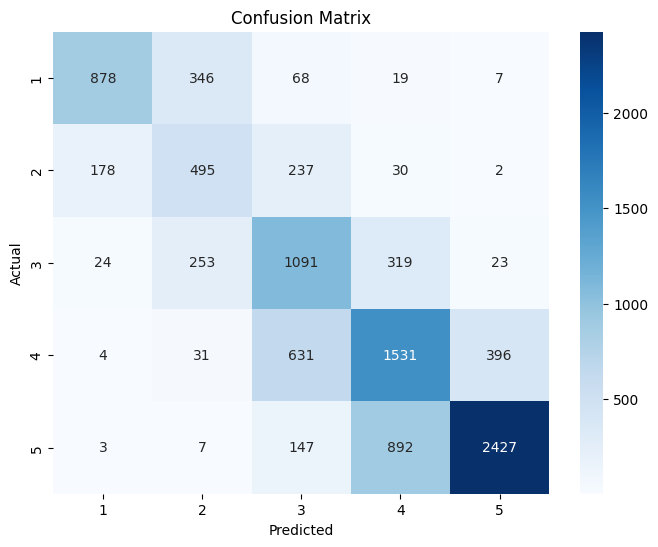

In [62]:
# Plotting the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Visualization** - Plotting the Per-Class Accuracy Graph for the evaluation of the LSTM Model.

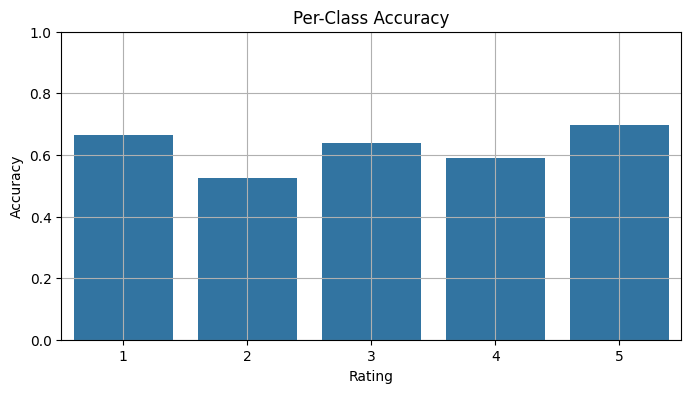

In [64]:
# Plotting the Per-Class Accuracy graph
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(range(1, 6)), y=class_accuracy)
plt.title("Per-Class Accuracy")
plt.xlabel("Rating")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

### 2. Prediction using DistilBERT

**Tokenize Review Text** - Tokenizes the input text using DistilBERT tokenizer with attention masks for model input and defining Structured Features.

In [67]:
# Tokenizing review_text
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
encoded = tokenizer(
    df['review_text'].tolist(),
    padding='longest',  # dynamic padding
    truncation=True,
    return_tensors='tf',
    max_length=64
)

input_ids = encoded['input_ids']
attention_mask = encoded['attention_mask']

# Structured features - top correlated only
structured_cols = [
    'senior_mgmt', 'culture_values', 'career_opp',
    'comp_benefits', 'work_life_balance', 'ceo_approv',
    'pros_sentiment', 'cons_sentiment', 'headline_sentiment',
    'tfidf_sum', 'tfidf_max', 'tfidf_nonzero',
    'work_culture_interaction', 'career_comp_interaction'
]
df[structured_cols] = df[structured_cols].apply(lambda x: x.fillna(x.median()))

# Converting ratings to class labels (0–4)
df['rating_class'] = df['overall_rating'].astype(int) - 1  # shifting to 0-based indexing
structured_input = tf.convert_to_tensor(df[structured_cols].values, dtype=tf.float32)
y = tf.convert_to_tensor(df['rating_class'].values, dtype=tf.int32)

**Split Dataset for Training & Validation and finding the best parameters** - Converts tokenized tensors to NumPy and performs a train-test split. Also deciding the best paramters for the model.

In [69]:
# Converting tensors to numpy
X_ids = input_ids.numpy()
X_mask = attention_mask.numpy()
X_struct = structured_input.numpy()
y_np = y.numpy()

# Splitting into Train/test
X_ids_train, X_ids_val, X_mask_train, X_mask_val, X_struct_train, X_struct_val, y_train, y_val = train_test_split(
    X_ids, X_mask, X_struct, y_np, test_size=0.2, random_state=42
)

# Subclassed Model
class BertFusionModel(tf.keras.Model):
    def __init__(self, units=64, dropout_rate=0.3):
        super().__init__()
        self.bert = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
        self.bert.trainable = False

        self.struct_dense = Dense(units, activation='relu')
        self.struct_proj = Dense(768, activation='relu')
        self.expand_bert = Lambda(lambda x: tf.expand_dims(x, axis=1))
        self.expand_struct = Lambda(lambda x: tf.expand_dims(x, axis=1))
        self.attn = Attention(use_scale=True) 
        self.squeeze = Lambda(lambda x: tf.squeeze(x, axis=1))

        self.concat = Concatenate()
        self.bn = BatchNormalization()
        self.dropout1 = Dropout(dropout_rate)
        self.hidden = Dense(units, activation='relu')
        self.dropout2 = Dropout(dropout_rate)
        self.out = Dense(5, activation='softmax')

    def call(self, inputs):
        input_ids, attention_mask, structured_input = inputs
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        struct_dense = self.struct_dense(structured_input)
        struct_proj = self.struct_proj(struct_dense)

        bert_exp = self.expand_bert(bert_out)
        struct_exp = self.expand_struct(struct_proj)
        attn = self.attn([bert_exp, struct_exp, struct_exp])
        attn = self.squeeze(attn)

        x = self.concat([bert_out, attn, struct_dense])
        x = self.bn(x)
        x = self.dropout1(x)
        x = self.hidden(x)
        x = self.dropout2(x)
        return self.out(x)

# Optimizer selector
def get_optimizer(name):
    return Adam() if name == "adam" else Adamax()

# Hyperparameter grid
param_grid = {
    "optimizer": ["adam", "adamax"],
    "dropout_rate": [0.2, 0.3],
    "units": [64, 128],
    "batch_size": [16, 32],
    "epochs": [3]
}

# Manual Grid Search
best_score = 0
best_params = None
best_model = None

X_val_input = [X_ids_val[:300], X_mask_val[:300], X_struct_val[:300]]
y_val_input = y_val[:300]

for combo in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    print("Trying params:", params)

    model = BertFusionModel(units=params["units"], dropout_rate=params["dropout_rate"])
    model.compile(optimizer=get_optimizer(params["optimizer"]), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        [X_ids_train[:1000], X_mask_train[:1000], X_struct_train[:1000]],
        y_train[:1000],
        validation_data=(X_val_input, y_val_input),
        epochs=params["epochs"],
        batch_size=params["batch_size"],
        verbose=0
    )

    loss, acc = model.evaluate(X_val_input, y_val_input, verbose=0)
    print(f"Accuracy: {acc:.4f} | Loss: {loss:.4f}")

    if acc > best_score:
        best_score = acc
        best_params = params
        best_model = model

print("Best Hyperparameters:", best_params)
print("Best Accuracy Achieved:", best_score)

Trying params: {'optimizer': 'adam', 'dropout_rate': 0.2, 'units': 64, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5900 | Loss: 0.9972
Trying params: {'optimizer': 'adam', 'dropout_rate': 0.2, 'units': 64, 'batch_size': 32, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5733 | Loss: 1.0727
Trying params: {'optimizer': 'adam', 'dropout_rate': 0.2, 'units': 128, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5967 | Loss: 1.0065
Trying params: {'optimizer': 'adam', 'dropout_rate': 0.2, 'units': 128, 'batch_size': 32, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5533 | Loss: 1.0561
Trying params: {'optimizer': 'adam', 'dropout_rate': 0.3, 'units': 64, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5667 | Loss: 1.0196
Trying params: {'optimizer': 'adam', 'dropout_rate': 0.3, 'units': 64, 'batch_size': 32, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5800 | Loss: 1.0195
Trying params: {'optimizer': 'adam', 'dropout_rate': 0.3, 'units': 128, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5800 | Loss: 1.0017
Trying params: {'optimizer': 'adam', 'dropout_rate': 0.3, 'units': 128, 'batch_size': 32, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.6167 | Loss: 1.0224
Trying params: {'optimizer': 'adamax', 'dropout_rate': 0.2, 'units': 64, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5733 | Loss: 1.0049
Trying params: {'optimizer': 'adamax', 'dropout_rate': 0.2, 'units': 64, 'batch_size': 32, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5933 | Loss: 0.9801
Trying params: {'optimizer': 'adamax', 'dropout_rate': 0.2, 'units': 128, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5767 | Loss: 0.9910
Trying params: {'optimizer': 'adamax', 'dropout_rate': 0.2, 'units': 128, 'batch_size': 32, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5467 | Loss: 1.0354
Trying params: {'optimizer': 'adamax', 'dropout_rate': 0.3, 'units': 64, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5767 | Loss: 1.0974
Trying params: {'optimizer': 'adamax', 'dropout_rate': 0.3, 'units': 64, 'batch_size': 32, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5600 | Loss: 1.0272
Trying params: {'optimizer': 'adamax', 'dropout_rate': 0.3, 'units': 128, 'batch_size': 16, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5333 | Loss: 1.0878
Trying params: {'optimizer': 'adamax', 'dropout_rate': 0.3, 'units': 128, 'batch_size': 32, 'epochs': 3}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Accuracy: 0.5767 | Loss: 1.0391
Best Hyperparameters: {'optimizer': 'adam', 'dropout_rate': 0.3, 'units': 128, 'batch_size': 32, 'epochs': 3}
Best Accuracy Achieved: 0.6166666746139526


**Compute Class Weights, Compiling and Model Fitting** - Calculates weights for imbalanced classes to improve model training fairness, Compiling the model and fitting the model with the best parameters.

In [71]:
# Calculating class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Converting to dict format required by Keras
class_weight_dict = dict(enumerate(class_weights))

# Final Model with best hyperparameters
final_model = BertFusionModel(units=best_params["units"], dropout_rate=best_params["dropout_rate"])

final_model.compile(
    optimizer=get_optimizer(best_params["optimizer"]),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Setting up callbacks
early_stopping = EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor='val_loss'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2
)

def lr_logging(epoch, lr):
    print(f"Epoch {epoch+1}: Learning Rate = {lr}")
    return lr

lr_scheduler = LearningRateScheduler(
    lambda epoch: lr_logging(epoch, 1e-5 * 10 ** (epoch / 20))
)

# 4. Retraining the final model on the full training set
history = final_model.fit(
    [X_ids_train, X_mask_train, X_struct_train],
    y_train,
    validation_data=([X_ids_val, X_mask_val, X_struct_val], y_val),
    epochs=20,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr, lr_scheduler],
    class_weight=class_weight_dict  # Handling class imbalance
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1: Learning Rate = 1e-05
Epoch 1/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 1446s 1s/step - accuracy: 0.4370 - loss: 1.3425 - val_accuracy: 0.5837 - val_loss: 0.9767 - learning_rate: 1.0000e-05
Epoch 2: Learning Rate = 1.1220184543019635e-05
Epoch 2/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 1445s 1s/step - accuracy: 0.5866 - loss: 1.0141 - val_accuracy: 0.5923 - val_loss: 0.9379 - learning_rate: 1.1220e-05
Epoch 3: Learning Rate = 1.2589254117941673e-05
Epoch 3/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 1458s 1s/step - accuracy: 0.5995 - loss: 0.9613 - val_accuracy: 0.6055 - val_loss: 0.9115 - learning_rate: 1.2589e-05
Epoch 4: Learning Rate = 1.4125375446227545e-05
Epoch 4/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 1442s 1s/step - accuracy: 0.6113 - loss: 0.9391 - val_accuracy: 0.6091 - val_loss: 0.8870 - learning_rate: 1.4125e-05
Epoch 5: Learning Rate = 1.5848931924611138e-05
Epoch 5/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 1435s 1s/step - accuracy: 0.6157 - loss: 0.9178 - val_accuracy: 0.6146 - val_loss: 0.8934 - lea

**Enable Fine-Tuning on DistilBERT** - Unfreezes the pre-trained DistilBERT model and lowers the learning rate for training.

In [73]:
# Unfreezing DistilBERT for fine-tuning
final_model.bert.trainable = True
print("Unfroze DistilBERT — starting fine-tuning...")

# Recompiling with a lower learning rate
optimizer = Adam(learning_rate=2e-5)  # Clean and simple
final_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Fine-tuning the final model for a few more epochs
history = final_model.fit(
    [X_ids_train, X_mask_train, X_struct_train],
    y_train,
    validation_data=([X_ids_val, X_mask_val, X_struct_val], y_val),
    epochs=20,
    batch_size=best_params['batch_size'],
    callbacks=[early_stopping, reduce_lr, lr_scheduler],
    class_weight=class_weight_dict
)

Unfroze DistilBERT — starting fine-tuning...
Epoch 1: Learning Rate = 1e-05
Epoch 1/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 1515s 1s/step - accuracy: 0.6486 - loss: 0.8490 - val_accuracy: 0.6424 - val_loss: 0.8169 - learning_rate: 1.0000e-05
Epoch 2: Learning Rate = 1.1220184543019635e-05
Epoch 2/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 1495s 1s/step - accuracy: 0.6523 - loss: 0.8408 - val_accuracy: 0.6402 - val_loss: 0.8204 - learning_rate: 1.1220e-05
Epoch 3: Learning Rate = 1.2589254117941673e-05
Epoch 3/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 1494s 1s/step - accuracy: 0.6506 - loss: 0.8447 - val_accuracy: 0.6381 - val_loss: 0.8261 - learning_rate: 6.2946e-06
Epoch 4: Learning Rate = 1.4125375446227545e-05
Epoch 4/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 1496s 1s/step - accuracy: 0.6501 - loss: 0.8458 - val_accuracy: 0.6350 - val_loss: 0.8318 - learning_rate: 1.4125e-05


**Model Summary** - Displays the architecture and layer details of the DistilBERT model with structured input.

In [75]:
final_model.summary()

Model: "bert_fusion_model_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 768)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_48 (Lambda)              │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_49 (Lambda)              │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_16 (Attention)        │ (None, 1, 768)         │             1 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_50 (Lambda)              │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ concatenate_33 (Concatenate)    │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 1664)           │         6,656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 128)            │       213,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 957,588 (3.65 MB)

 Trainable params: 318,086 (1.21 MB)

 Non-trainable params: 3,328 (13.00 KB)

 Optimizer params: 636,174 (2.43 MB)

**Save Trained Model** - Exports the trained model to HDF5 format for future use.

In [77]:
# Saving the model in HDF5 format
model.save("distilbert_structured_model.h5")
print("Model saved successfully as distilbert_structured_model.h5")

Model saved successfully as distilbert_structured_model.h5


**Training Accuracy Visualization** - Plots training and validation accuracy/loss trends to evaluate model performance.

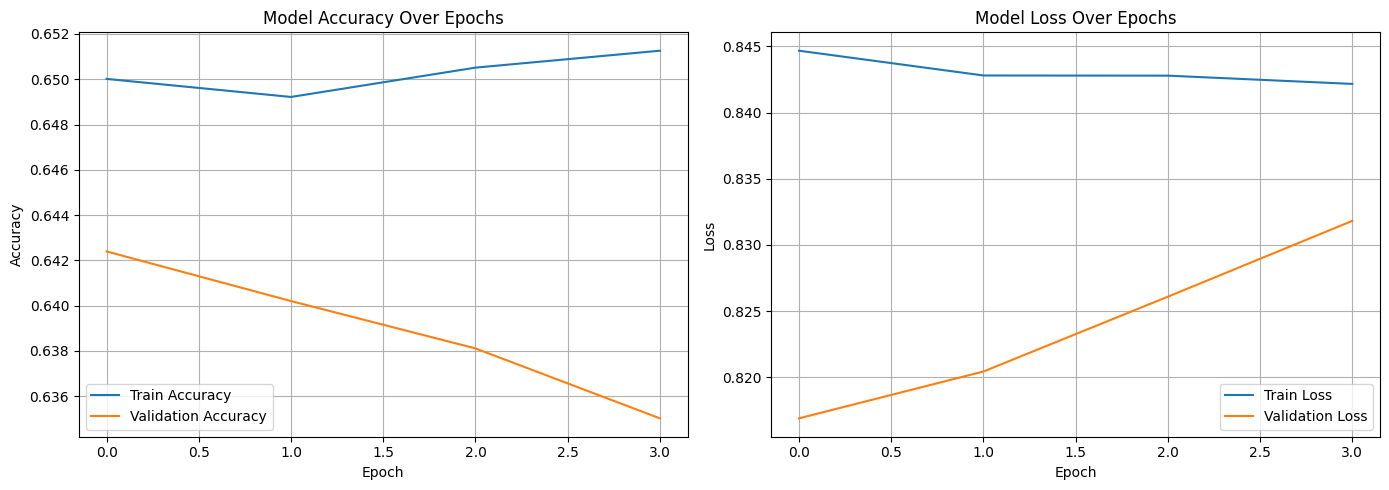

In [79]:
# Plotting accuracy over epochs
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plotting loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Model Predictions & Evaluation** - Uses the trained model to predict on validation data and prints a classification report.

314/314 ━━━━━━━━━━━━━━━━━━━━ 303s 963ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.77      0.72      1318
           1       0.50      0.00      0.00       942
           2       0.42      0.66      0.51      1710
           3       0.49      0.18      0.26      2593
           4       0.63      0.90      0.74      3476

    accuracy                           0.57     10039
   macro avg       0.54      0.50      0.45     10039
weighted avg       0.55      0.57      0.51     10039



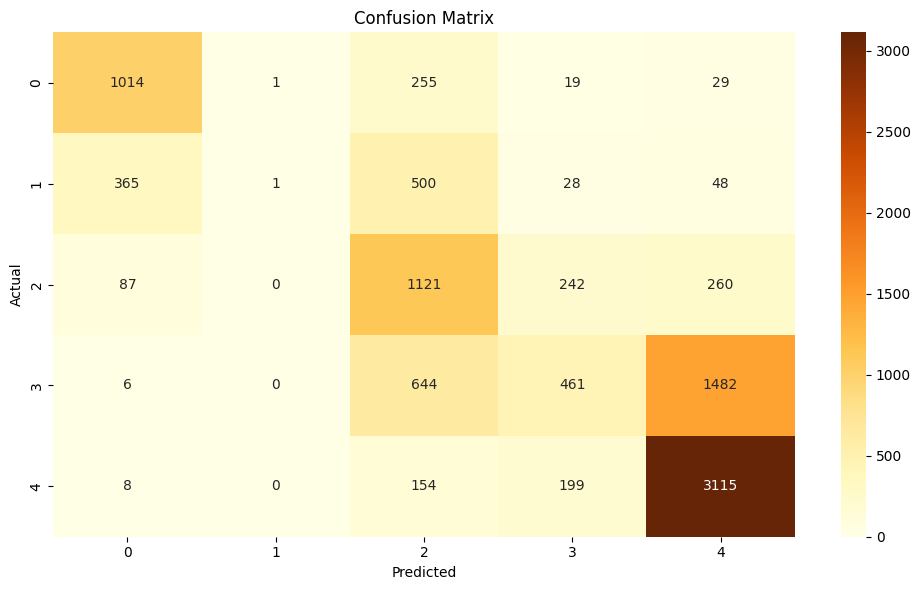

In [81]:
# Predict class probabilities and take argmax
y_pred_probs = model.predict([X_ids_val, X_mask_val, X_struct_val])
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_val, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='YlOrBr')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

**Rounded Prediction Accuracy** - Rounds predicted and actual ratings to nearest integers (1–5 scale) and calculates accuracy.

In [83]:
# Rounding off predictions and labels to nearest integer
rounded_preds = np.round(y_pred).clip(1, 5)
rounded_labels = np.round(y_val).clip(1, 5)

# Accuracy
accuracy = np.mean(rounded_preds.flatten() == rounded_labels)
print(f"Rounded Accuracy (±0): {accuracy * 100:.2f}%")

Rounded Accuracy (±0): 60.54%


**Accuracy Evaluation** - Accuracy per class for DistilBERT.

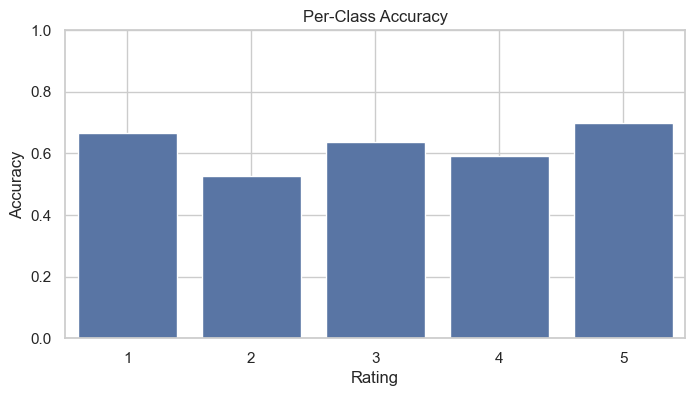

In [112]:
conf_matrixdb = confusion_matrix(y_val, y_pred)

# Plotting the Per-Class Accuracy graph
class_accuracy_DB = conf_matrixdb.diagonal() / conf_matrixdb.sum(axis=1)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(range(1, 6)), y=class_accuracy)
plt.title("Per-Class Accuracy")
plt.xlabel("Rating")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

### 2. Interpretation (Explainability)
1. **Inference on a Sample Review** - Selects a single random review, tokenizes it, and prepares structured input for prediction.
2. **SHAP (SHapley Additive Explanations) using the Distil BERT Model** - Structuring, getting Text and Structured Values and Merging SHAP explanations.
3. **Visualizing SHAP Explanations** - Plotting Text-Only Force Plot, Combined SHAP Explanations and SHAP contributing Summary (Positive and Negative values).

**SHAP Explainer** - Using SHAP Explainer for Text-Only to explain the favourity of the words and its impact using force plot.

In [86]:
# Sampling a single review
sample = df.sample(1, random_state=42)
text = sample["review_text"].values[0]

# Structured input
structured_cols = [
    'senior_mgmt', 'culture_values', 'career_opp',
    'comp_benefits', 'work_life_balance', 'ceo_approv',
    'pros_sentiment', 'cons_sentiment', 'headline_sentiment',
    'tfidf_sum', 'tfidf_max', 'tfidf_nonzero',
    'work_culture_interaction', 'career_comp_interaction'
]
structured_input = sample[structured_cols].values.astype("float32")


# Text SHAP Explainer
def predict_text(texts):
    texts = [str(t) for t in texts]
    tokens = tokenizer(texts, padding="max_length", truncation=True, max_length=64, return_tensors="tf")
    batch_struct = tf.convert_to_tensor(np.repeat(structured_input, len(texts), axis=0), dtype=tf.float32)
    return model([tokens["input_ids"], tokens["attention_mask"], batch_struct]).numpy()

text_masker = shap.maskers.Text(tokenizer)
text_explainer = shap.Explainer(predict_text, text_masker)
text_shap = text_explainer([text])[0]

# Visualization of the Summary
print("\nToken-level Force Plot (Text Only):")
shap.plots.text(text_shap)

PartitionExplainer explainer: 2it [00:18, 18.78s/it]               


Token-level Force Plot (Text Only):


**Structured SHAP Explainer** - Combined SHAP Explainer combining text and structered inputs and displaying in a bar graph.


Combined SHAP Bar Chart (Text + Structured):


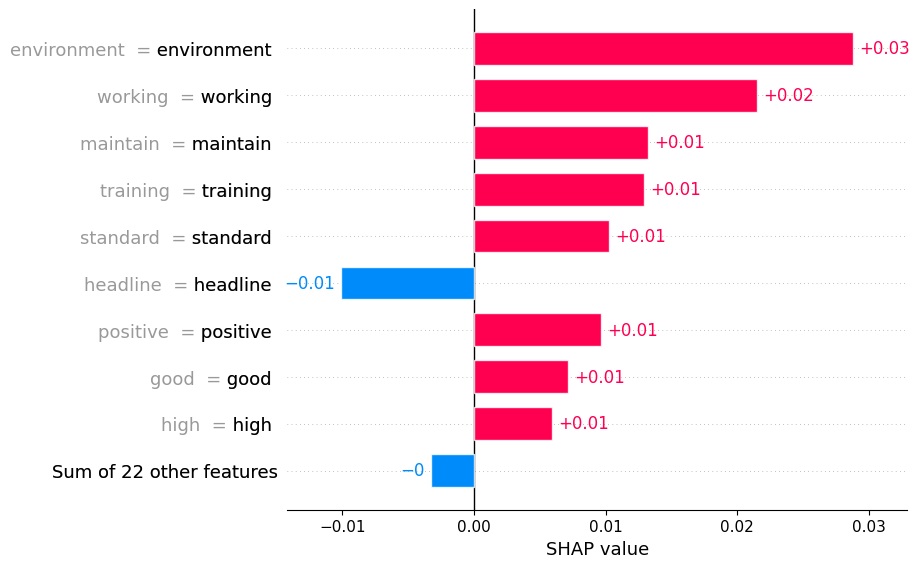

In [88]:
# Structured SHAP Explainer
def predict_structured(struct_vals):
    tokens = tokenizer([text] * len(struct_vals), padding="max_length", truncation=True, max_length=64, return_tensors="tf")
    struct_tensor = tf.convert_to_tensor(struct_vals.astype("float32"))
    return model([tokens["input_ids"], tokens["attention_mask"], struct_tensor]).numpy()

structured_explainer = shap.Explainer(predict_structured, structured_input)
structured_shap = structured_explainer(structured_input)[0]


# Getting SHAP Values
# Get predicted class index
target_index = np.argmax(predict_text([text])[0])

# Text
text_vals = text_shap.values[:, target_index]
text_data = text_shap.data[0] if isinstance(text_shap.data[0], list) else text_shap.data

assert len(text_vals) == len(text_data), f"text_vals: {len(text_vals)}, tokens: {len(text_data)}"

# Structured
structured_vals = structured_shap.values[:, target_index]
assert len(structured_vals) == len(structured_cols), "Mismatch in structured SHAP values and columns"


# Merge SHAP Explanations
combined_values = np.concatenate([text_vals, structured_vals])
combined_data = np.concatenate([text_data, structured_shap.data.flatten()])
combined_names = list(text_data) + list(structured_cols)

assert len(combined_values) == len(combined_names), "Mismatch in final merge"

combined_explanation = shap.Explanation(
    values=combined_values,
    base_values=text_shap.base_values[target_index],
    data=combined_data,
    feature_names=combined_names
)

print("\nCombined SHAP Bar Chart (Text + Structured):")
shap.plots.bar(combined_explanation)

**Contribution Summary** - Displays the contribution summary of the words that impacts the model either positively or negatively.

In [90]:
# Summary function
def explain_review_summary(text_vals, text_data, structured_vals, structured_cols, top_n=5):
    text_df = pd.DataFrame({
        "feature": text_data,
        "shap_value": text_vals,
        "type": "text"
    })

    structured_df = pd.DataFrame({
        "feature": structured_cols,
        "shap_value": structured_vals,
        "type": "structured"
    })

    combined_df = pd.concat([text_df, structured_df], ignore_index=True)
    combined_df["abs_value"] = combined_df["shap_value"].abs()

    pos = combined_df[combined_df["shap_value"] > 0].sort_values("shap_value", ascending=False).head(top_n)
    neg = combined_df[combined_df["shap_value"] < 0].sort_values("shap_value", ascending=True).head(top_n)

    print("\nTop Positive Contributors:")
    for _, row in pos.iterrows():
        print(f"   - {row['feature']} ({row['type']}) → +{row['shap_value']:.3f}")

    if neg.empty:
        print("\nTop Negative Contributors: (no strong negatives, showing fallback)")
        fallback = combined_df.sort_values("shap_value", ascending=True).head(top_n)
        for _, row in fallback.iterrows():
            print(f"   - {row['feature']} ({row['type']}) → {row['shap_value']:.3f}")
    else:
        print("\nTop Negative Contributors:")
        for _, row in neg.iterrows():
            print(f"   - {row['feature']} ({row['type']}) → {row['shap_value']:.3f}")

    return combined_df

print("\nSHAP Contribution Summary:")
summary_df = explain_review_summary(text_vals, text_data, structured_vals, structured_cols)


SHAP Contribution Summary:

Top Positive Contributors:
   - environment  (text) → +0.029
   - working  (text) → +0.022
   - maintain  (text) → +0.013
   - training  (text) → +0.013
   - standard  (text) → +0.010

Top Negative Contributors:
   - headline  (text) → -0.010
   - manager  (text) → -0.006
   - pro  (text) → -0.003
   - great  (text) → -0.000


### 3. Temporal Insight
**Tokenize All Reviews for Inference** - Converts all reviews and structured inputs into tensors for batch predictions.

In [92]:
# Ensuring structured input is tensor
structured_tensor = tf.convert_to_tensor(df[structured_cols].values, dtype=tf.float32)
texts = df["review_text"]

# Tokenizing all texts
tokens = tokenizer(
    texts.tolist(),
    padding="max_length",
    truncation=True,
    max_length=64,
    return_tensors="tf"
)

# Building dataset
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": tokens["input_ids"],
        "attention_mask": tokens["attention_mask"],
        "structured_data": structured_tensor
    }
)).batch(batch_size)

# Predicting in batches
predictions = []
for batch in tqdm(dataset, desc="Predicting"):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    struct_data = batch["structured_data"]
    preds = model([input_ids, attention_mask, struct_data], training=False)
    predictions.extend(tf.argmax(preds, axis=1).numpy())  # you can keep softmax values if needed

# Saving to DataFrame
df["predicted_rating"] = predictions

Predicting: 100%|██████████| 1569/1569 [28:36<00:00,  1.09s/it]


**Plotting Satisfaction Trend by Top Job Titles** - Helps identify which job roles are improving/declining in satisfaction.

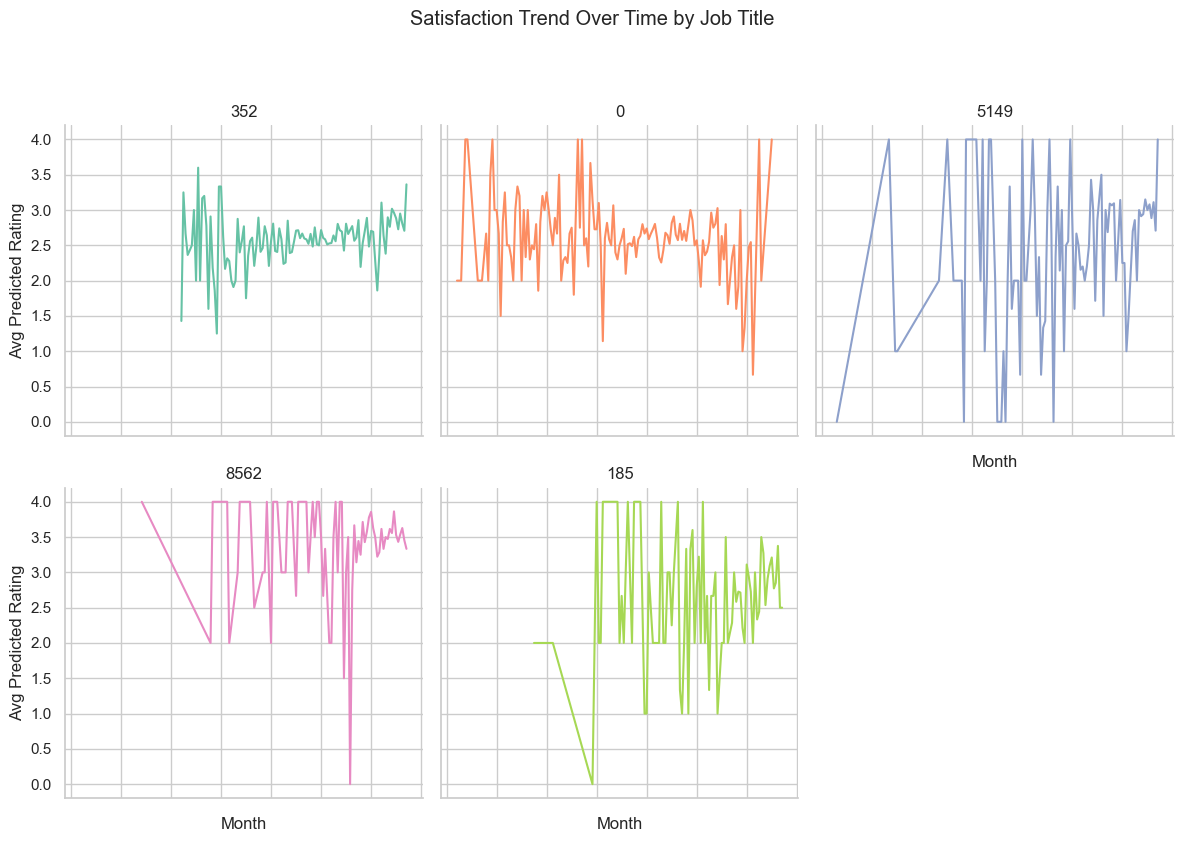

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Converting review date to datetime and extract year-month
df["date_review"] = pd.to_datetime(df["date_review"], errors='coerce')
df["year_month"] = df["date_review"].dt.to_period("M").astype(str)

# Getting top 5 job titles by number of reviews
top_titles = df["job_title"].value_counts().nlargest(5).index
df_title = df[df["job_title"].isin(top_titles)].copy()

# Converting year_month to datetime for plotting
df_title["year_month"] = pd.to_datetime(df_title["year_month"])

# Aggregating average predicted rating per month per job title
grouped = df_title.groupby(["year_month", "job_title"])["predicted_rating"].mean().reset_index()

# FacetGrid for separate plots per job title
sns.set(style="whitegrid")
g = sns.FacetGrid(grouped, col="job_title", col_wrap=3, height=4, sharey=True)

# Each subplot will have its own colored line
for i, title in enumerate(top_titles):
    subset = grouped[grouped["job_title"] == title]
    ax = g.axes.flatten()[i]
    sns.lineplot(data=subset, x="year_month", y="predicted_rating", ax=ax, color=sns.color_palette("Set2")[i])
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

g.set_axis_labels("Month", "Avg Predicted Rating")
g.fig.suptitle("Satisfaction Trend Over Time by Job Title", y=1.05)
plt.tight_layout()
plt.show()

**Satisfaction Trend by Location** - Reveals geographic patterns in sentiment shifts.

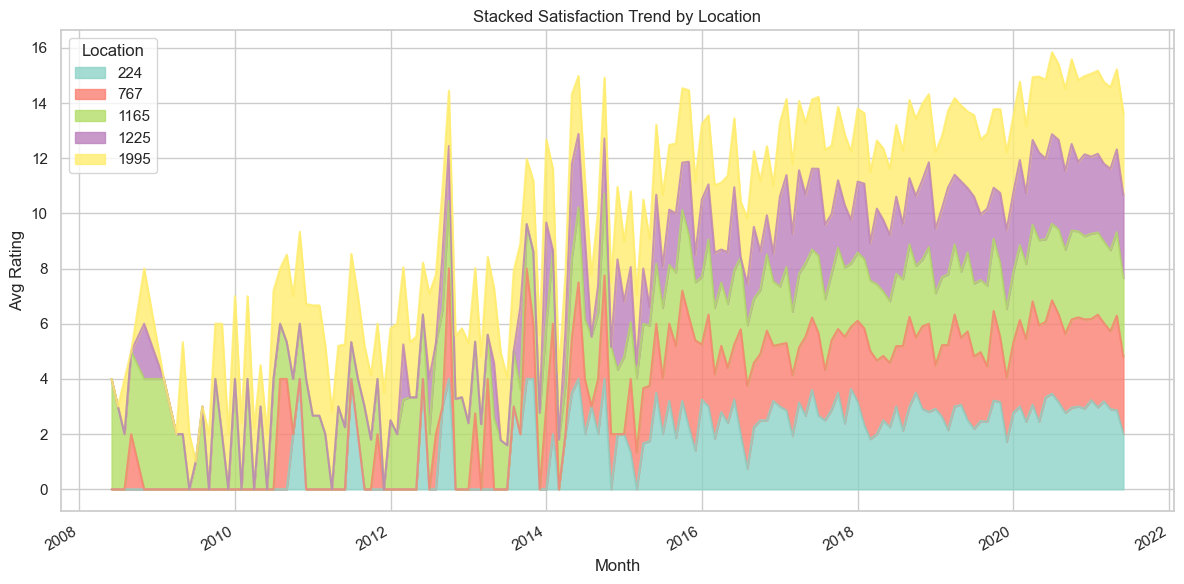

In [103]:
top_locations = df["location"].value_counts().nlargest(5).index.tolist()
df_loc = df[df["location"].isin(top_locations)]

pivot = df_loc.groupby(["year_month", "location"])["predicted_rating"].mean().unstack()
pivot.index = pd.to_datetime(pivot.index)

pivot.plot.area(figsize=(12, 6), colormap='Set3', alpha=0.8)
plt.title("Stacked Satisfaction Trend by Location")
plt.xlabel("Month")
plt.ylabel("Avg Rating")
plt.legend(title="Location")
plt.grid(True)
plt.tight_layout()
plt.show()

**Top SHAP Words in a month** - Shows which words become more or less influential in a single sample month.

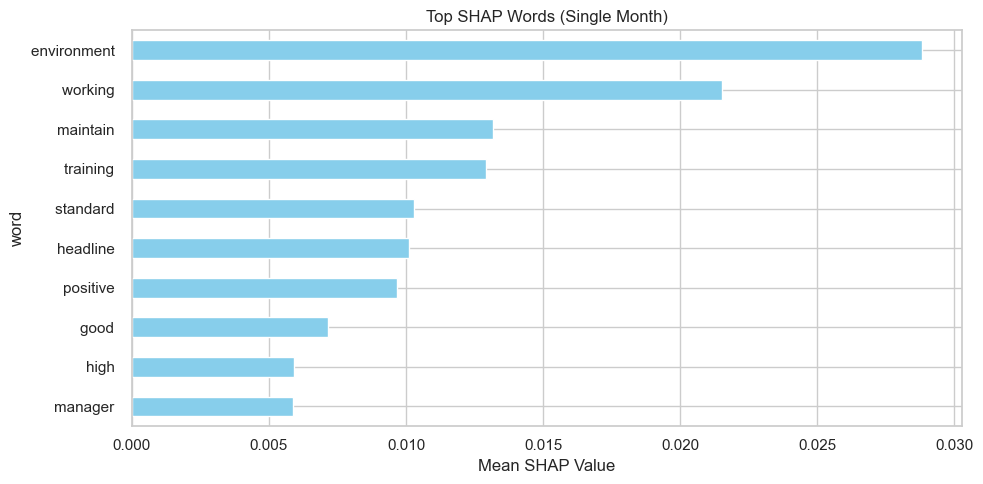

In [105]:
# Creating shap_df just for the sampled review
shap_df = pd.DataFrame({
    'word': text_data,
    'shap_value': text_vals
})

# Adding the review's month for reference (if available)
if "date_review" in sample.columns:
    shap_df['year_month'] = sample["date_review"].dt.to_period("M").astype(str).values[0]

top_words = shap_df.groupby('word')['shap_value'].mean().abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_words.sort_values().plot(kind='barh', color='skyblue')
plt.title("Top SHAP Words (Single Month)")
plt.xlabel("Mean SHAP Value")
plt.tight_layout()
plt.show()

**Top Positive/Negative Words Per Month** - Easy-to-understand summary of what’s making people happy or upset each month.

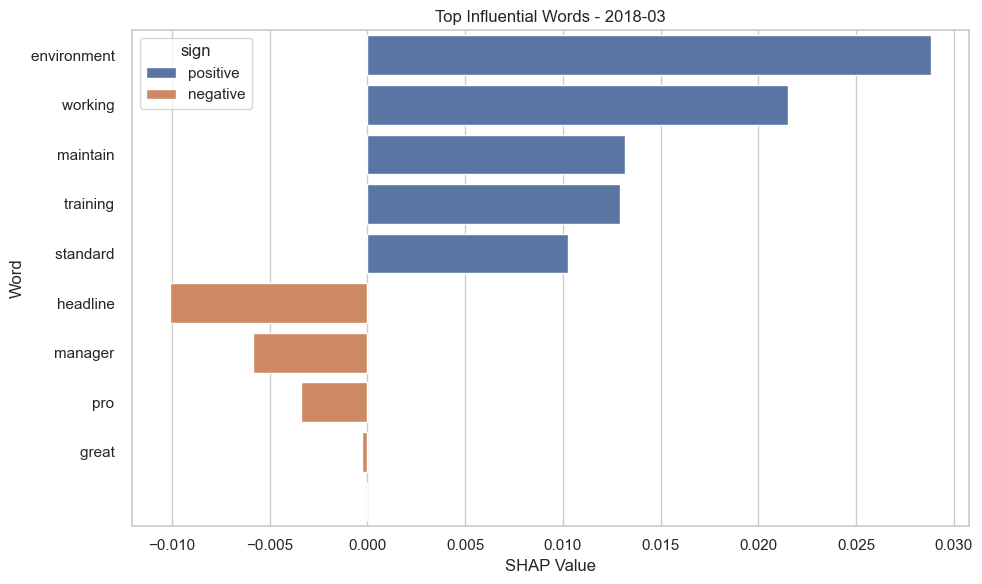

In [107]:
# Top 5 positive and negative SHAP words per month
monthly_words = shap_df.copy()
monthly_words['sign'] = monthly_words['shap_value'].apply(lambda x: 'positive' if x > 0 else 'negative')

for month in monthly_words['year_month'].unique():
    subset = monthly_words[monthly_words['year_month'] == month]
    top_words = pd.concat([
        subset.nlargest(5, 'shap_value'),
        subset.nsmallest(5, 'shap_value')
    ])
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_words, x='shap_value', y='word', hue='sign')
    plt.title(f"Top Influential Words - {month}")
    plt.xlabel("SHAP Value")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

**Before & After Event Comparison** - Compare average satisfaction and SHAP word usage before vs. after.

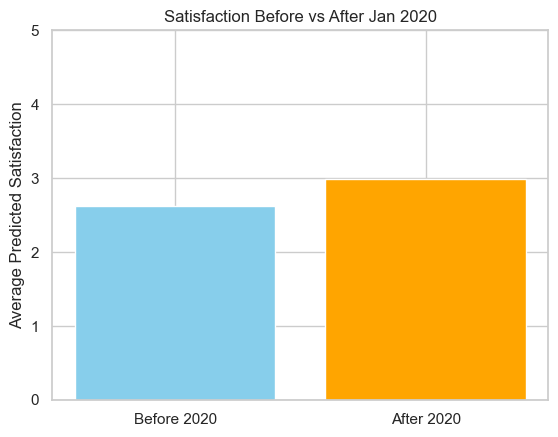

In [109]:
# Defining a pivot date
pivot_date = pd.to_datetime("2020-01-01")

# Creating two slices
before = df[df["date_review"] < pivot_date]
after = df[df["date_review"] >= pivot_date]

# Comparing average satisfaction
avg_before = before["predicted_rating"].mean()
avg_after = after["predicted_rating"].mean()

# Plotting Bar plot
plt.bar(["Before 2020", "After 2020"], [avg_before, avg_after], color=["skyblue", "orange"])
plt.ylabel("Average Predicted Satisfaction")
plt.title("Satisfaction Before vs After Jan 2020")
plt.ylim(0, 5)
plt.grid(True)
plt.show()